In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


# Load the Dataset

In [ ]:
## Standard cast into Tensor and pixel values normalization in [-1, 1] range
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
])

## Download train dataset
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
## Download test dataset
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler


## Number of subprocesses to use for data loading
NUM_WORKERS = 2

## Load the data to loaders (train and test)
def load_data(train_set, test_set, batch_size):
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, num_workers=NUM_WORKERS
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, num_workers=NUM_WORKERS
    )

    return train_loader, test_loader

## Load the data with batch_size = 16
train_loader, test_loader = load_data(train_set, test_set, 16)

In [ ]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

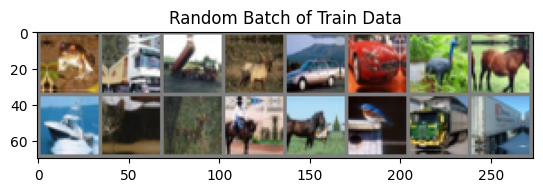

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## This function shows a random batch of data, batch_size is 16

def show_image(train_loader):
  dataiter = iter(train_loader)
  features, labels = next(dataiter)
  img = torchvision.utils.make_grid(features)
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title('Random Batch of Train Data')
  plt.show()


show_image(train_loader)


In [ ]:
## Len of train_loader
train_loader.__len__()

3125

So it is 1563 batches, each consists of 32 images. Below we see the dimension of each sample in data loader:

In [ ]:
for i, (images, labels) in enumerate(train_loader):
    if i == 0:
        print(images.shape)
        print(labels.shape)
    else:
        break

torch.Size([32, 3, 32, 32])
torch.Size([32])


Number of all train samples:

In [ ]:
all_sample_num = 0
for i, (images, labels) in enumerate(train_loader):
    all_sample_num += images.shape[0]

all_sample_num

50000

Number of all test samples:

In [ ]:
all_sample_num = 0
for i, (images, labels) in enumerate(test_loader):
    all_sample_num += images.shape[0]

all_sample_num

10000

# Create the Model

This is the code for a single block:

In [ ]:
## Code for a single block
class ConvBlock(nn.Module):
    def __init__(self, input_size, block_size, input_channel, output_channel, max_pool):
        super(ConvBlock, self).__init__()
        """
        Initialise variables
        """
        ## List of parallel conv layers in the block
        self.conv_list = nn.ModuleList()
        ## Spatial size of the input enters to the block
        self.input_size = input_size
        ## Spatial size of output exit from the block --> it remains as same as input size, unless we use max pooling
        self.output_size = input_size
        ## This max_pool flag is to determine whether we use max pooling in this block or not, if we do, we should change the spatial size of the output
        if max_pool == True:
            self.output_size = int(self.output_size/2)
        ## Number of conv layers in the block
        self.block_size = block_size
        ## Number of the input channel to the block
        self.input_channel = input_channel
        ## Number of output channel from the block
        self.output_channel = output_channel
        ## Flag for using max pooling in the block or not
        self.max_pool = max_pool

        """
        Convolution part
        """
        ## A loop with size of conv layers
        """ Initialise each parallel conv layer:
                1- Convolution Layer
                2- Batch Norm
                3- ReLU activation function (to add non-linearity)
                4- Dropout to address overfiting
                *** Note: look at kernel size and padding, they will change based on the block_size and also iterator i.
                    It means that for example in case of having 2 parallel conv layers, the first one has kernel_size = 3 and padding = 1, and the next one
                    will have kernel_size = 5 and padding = 2. I did this and used different kernel size to be able to capture different features from the image
            """
        for i in range(0, self.block_size):
            conv = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channel, out_channels=self.output_channel, kernel_size = 2*(i+1)+1, stride = 1, padding = i+1),
            nn.BatchNorm2d(self.output_channel),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
            )
            ## Add this to the list
            self.conv_list.append(conv)
        
        ## Initialise the max pool layer (using of it in forward path will depend on the max_pool flag defined above)
        self.max_pool_layer = nn.MaxPool2d(2)
            

        """
        Coefficients part
        """
        ## Average pool layer ---> output: [y1, y2, ..., yd] which d is number of channel in input
        self.average_pool = nn.AvgPool2d(self.input_size)

        """ 
        An MLP for generating the coefficients, it maps the input_channel number of features to the block_size, which is the number of conv layers.
        It consists of:
            1- Linear layer with ReLU activation function
            2- Dropout
            3- Linear layer with Softmax activation function, to generate the weights (coefficients)
        """
        self.coefficients = nn.Sequential(
            nn.Linear(self.input_channel, self.block_size*2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(self.block_size*2, self.block_size),
            nn.Softmax(dim=1)
        )
    
    def forward(self, X):
        """
        Convolution part --> Forward path
        """
        conv_list_ = []
        for conv in self.conv_list:
            conv_list_.append(conv(X))

        ## Convert to tensor by stack --> The dimension will be: (batch_size, number_of_conv_layers, number_of_output_channels, input_size, input_size)
        conv_tensor = torch.stack(conv_list_, dim=1)

        """
        Coefficients part --> Forward path
        """
        ## Computing coefficients
        coefficients = self.coefficients(self.average_pool(X).squeeze())
        ## Unsqueeze for broadcasting
        coefficients = coefficients[:, :, None, None, None]

        """
        Creating the output of block using coefficients and conv layers
        """
        ## Multiplying convolutions with corresponding coefficients
        block_output = conv_tensor * coefficients

        ## Add them up on second dimension
        block_output = torch.sum(block_output, dim=1)

        ## Check for using max_pool layer or not
        if self.max_pool == True:
            block_output = self.max_pool_layer(block_output)

        return block_output
            


### Backbone - Style #1

In [ ]:
## Code for the Backbone
class Backbone1(nn.Module):
    ## Note that output channels should be tuple (channel_block1, channel_block2, ...)
    def __init__(self, num_classes, num_block, block_size, output_channel, max_pool):
        super(Backbone1, self).__init__()
        """
        Initialise variables
        """
        ## List of blocks
        self.block_list = nn.ModuleList()
        ## List of residual blocks
        self.res_list = nn.ModuleList()
        ## Number of classification classes
        self.num_class = num_classes
        ## Number of blocks
        self.num_block = num_block
        ## Size of each block (number of conv layers in each block)
        self.block_size = block_size
        ## A list of numbers, showing number of output channel in each block
        self.output_channel = output_channel
        ## A list of flags for using max pool in layer in each block 
        self.max_pool = max_pool
        
        ## Define two variables for connecting the blocks to each other 
        curr_input_channel = 3
        curr_input_size = 32
        for i in range(0, self.num_block):
            ## Initialise block
            curr_block = ConvBlock(curr_input_size, block_size, curr_input_channel, output_channel[i], max_pool[i])
            ## Update the number of output channel and input size for the next block
            curr_input_channel = curr_block.output_channel
            curr_input_size = curr_block.output_size
            ## Add block to the list
            self.block_list.append(curr_block)

            """
            This part is for Residual Block, it consists of:
                    a- Conv layer with kernel_size = 1
                    b- Batch Norm
                    c- ReLU()
                    d- Dropout

            """
            ## Create Res block
            if i%2 == 1 and i != len(self.output_channel)-1:
                res = nn.Sequential(
                nn.Conv2d(in_channels=self.output_channel[i], out_channels=self.output_channel[i+2], kernel_size=1, stride=4),
                nn.BatchNorm2d(self.output_channel[i+2]),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
                )
                ## Add residual block to the list
                self.res_list.append(res)
        
        """
        Classification part
        """
        ## Average pooling before passing to the classifier
        self.final_average_pool = nn.AvgPool2d(curr_input_size)
        ## A Linear layer for classification
        ## Note: output_channel[-1] is the last block's channel number, which is fed to the classification
        self.class_out = torch.nn.Linear(output_channel[-1], num_classes, bias=True)
        torch.nn.init.xavier_uniform_(self.class_out.weight)
        ## Note: I didn't use softmax since my loss function will handle it
        

    def forward(self, X):

        ## Connect the blocks
        for i,block in enumerate(self.block_list):
            X = block(X)
            ## Add res block after each 2 consecutive conv block
            if i%2 == 1 and i != 1:
                X = X + self.res_list[int(i/2)-1](X_init_res)
            if i%2 == 1:
                X_init_res = X

        ## Squeeze the output of final_average_pool (befor doing classification)
        X = self.final_average_pool(X).squeeze()
        X = self.class_out(X)

        return X




### Backbone - Style #2

In [ ]:
## Code for the Backbone
class Backbone2(nn.Module):
    ## Note that output channels should be tuple (channel_block1, channel_block2, ...)
    def __init__(self, num_classes, num_block, block_size, output_channel, max_pool):
        super(Backbone2, self).__init__()
        """
        Initialise variables
        """
        ## List of blocks
        self.block_list = nn.ModuleList()
        ## List of residual blocks
        self.res_list = nn.ModuleList()
        ## Number of classification classes
        self.num_class = num_classes
        ## Number of blocks
        self.num_block = num_block
        ## Size of each block (number of conv layers in each block)
        self.block_size = block_size
        ## A list of numbers, showing number of output channel in each block
        self.output_channel = output_channel
        ## A list of flags for using max pool in layer in each block 
        self.max_pool = max_pool
        
        ## Define two variables for connecting the blocks to each other 
        curr_input_channel = 3
        curr_input_size = 32
        for i in range(0, self.num_block):
            ## Initialise block
            curr_block = ConvBlock(curr_input_size, block_size, curr_input_channel, output_channel[i], max_pool[i])
            ## Update the number of output channel and input size for the next block
            curr_input_channel = curr_block.output_channel
            curr_input_size = curr_block.output_size
            ## Add block to the list
            self.block_list.append(curr_block)

            """
            This part is for Residual Block, each block consists of:
                1- First Layer:
                    a- Conv layer with kernel_size = 3
                    b- Batch Norm
                    c- ReLU()
                    d- Dropout
                2- Second Layer:
                    a- Conv layer with kernel_size = 3
                    b- Batch Norm
                    c- ReLU()
                    d- Dropout
                Note: 
                1- This two layer are identical, and are connected to each other sequentially.
                2- This residual block will be added to the network after each two consecutive blocks
            """
            ## Create Res block
            if i%2 == 1:
                res = nn.Sequential(nn.Sequential(
                nn.Conv2d(in_channels=curr_input_channel, out_channels=curr_input_channel, kernel_size=3, padding=1),
                nn.BatchNorm2d(curr_input_channel),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
                ),      nn.Sequential(
                nn.Conv2d(in_channels=curr_input_channel, out_channels=curr_input_channel, kernel_size=3, padding=1),
                nn.BatchNorm2d(curr_input_channel),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2))
                )
                ## Add residual block to the list
                self.res_list.append(res)
        
        """
        Classification part
        """
        ## Average pooling before passing to the classifier
        self.final_average_pool = nn.AvgPool2d(curr_input_size)
        ## A Linear layer for classification
        ## Note: output_channel[-1] is the last block's channel number, which is fed to the classification
        self.class_out = torch.nn.Linear(output_channel[-1], num_classes, bias=True)
        torch.nn.init.xavier_uniform_(self.class_out.weight)
        ## Note: I didn't use softmax since my loss function will handle it
        

    def forward(self, X):

        ## Connect the blocks
        for i,block in enumerate(self.block_list):
            X = block(X)
            ## Add res block after each 2 consecutive conv block
            if i%2 == 1:
                X = X + self.res_list[int(i/2)](X)

        ## Squeeze the output of final_average_pool (befor doing classification)
        X = self.final_average_pool(X).squeeze()
        X = self.class_out(X)

        return X




# Train Script

In [ ]:
import time
from collections import defaultdict

def train(model, train_loader, test_loader, epochs, learning_rate):
    ## start the timer
    start = time.time()

    ## Define loss function as Cross Entropy
    loss_function = nn.CrossEntropyLoss()

    ## Define optimiser as Adam, then tell it to optimise model.parameters
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

    ## Define dictionaries and list for keeping loss and accuracy
    train_loss_dict = defaultdict(list)
    test_loss_dict = defaultdict(list)
    train_accuracy_list, test_accuracy_list = [], []

    ## Iterate on whole data to the number of epochs
    for epoch in range(epochs):
        acc_train_loss = 0
        ## Number of correct prediction
        correct = 0
        ## Number of all train samples
        total = 50000
        ## Iterate on data in each batch
        for i, (images, labels) in enumerate(train_loader):
            ## Assign images and labels to GPU
            images = images.to(device)
            labels = labels.to(device)
            ## Set the gradient as zero before starting of back propagation
            optimiser.zero_grad()
            ## Compute the prediction of model on train batch
            labels_pred = model(images)
            ## Compute loss
            train_loss = loss_function(labels_pred, labels)
            acc_train_loss += train_loss
            ## Do backpropagation --> This backward() compute the gradient w.r.t each parameter and store them in a Tensor
            train_loss.backward()
            ## Now we update each parameter using the gradients that backward computed and stored
            optimiser.step()
            ## Compute correct predicition on train set
            _, predicted = torch.max(labels_pred.data, 1)
            correct += (predicted == labels).sum().item()

        ## Compute train accuracy and add to list
        train_accuracy = 100 * correct / total
        train_accuracy_list.append(train_accuracy)
        ## Add train loss after each epoch
        ## This one is accumulated loss, which is sum of all loss for all the batches
        train_loss_dict['accumulated'].append(acc_train_loss)
        ## This one is average loss, which is average of all loss for all the batches
        train_loss_dict['mean'].append(acc_train_loss/i)

        ## Compute loss for test set (Validation)
        with torch.no_grad():
            acc_test_loss = 0
            ## Variables for computing accuracy
            correct = 0
            total = 10000
            for i, (images, labels) in enumerate(test_loader):
                ## Assign images and labels to GPU
                images = images.to(device)
                labels = labels.to(device)
                ## Compute the prediction of model on train batch
                labels_pred = model(images)
                ## Compute Loss
                test_loss = loss_function(labels_pred, labels)
                acc_test_loss += test_loss
                ## Compute correct predicition on test set
                _, predicted = torch.max(labels_pred.data, 1)
                correct += (predicted == labels).sum().item()

            ## Compute train accuracy and add to list
            test_accuracy = 100 * correct / total
            test_accuracy_list.append(test_accuracy)
            ## Add test loss
            ## This one is accumulated loss, which is sum of all loss for all the batches
            test_loss_dict['accumulated'].append(acc_test_loss)
            ## This one is average loss, which is average of all loss for all the batches
            test_loss_dict['mean'].append(acc_test_loss/i)
        
        ## Print result for current epoch
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(epoch+1, epochs, acc_train_loss, acc_test_loss, train_accuracy, test_accuracy))

    ## Finish the timer
    end = time.time()
    print('Total Elapsed Time for Traning: {} (s)'.format(end-start))

    return train_loss_dict, test_loss_dict, train_accuracy_list, test_accuracy_list


In [ ]:
## This function is for plotting the loss and accuracies
def plot_result(train_loss_dict, test_loss_dict, train_accuracy_list, test_accuracy_list):
    fig, axs = plt.subplots(ncols = 3, figsize=(24,8))

    train_loss_tens_acc = torch.Tensor(train_loss_dict['accumulated'])
    test_loss_tens_acc = torch.Tensor(test_loss_dict['accumulated'])

    train_loss_tens_avg = torch.Tensor(train_loss_dict['mean'])
    test_loss_tens_avg = torch.Tensor(test_loss_dict['mean'])

    train_acc_tens = torch.Tensor(train_accuracy_list)
    test_acc_tens = torch.Tensor(test_accuracy_list)

    axs[0].plot(list(range(len(train_loss_tens_acc))), train_loss_tens_acc, lw=2, color='blue', label='Train Loss')
    axs[0].plot(list(range(len(test_loss_tens_acc))), test_loss_tens_acc, lw=2, color='red', label='Test Loss')
    axs[0].set_title('Accumulated Loss Plot')
    axs[0].set_xlabel('Epochs')
    axs[0].legend()

    axs[1].plot(list(range(len(train_loss_tens_avg))), train_loss_tens_avg, lw=2, color='brown', label='Train Loss')
    axs[1].plot(list(range(len(test_loss_tens_avg))), test_loss_tens_avg, lw=2, color='pink', label='Test Loss')
    axs[1].set_title('Average Loss Plot')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()

    axs[2].plot(list(range(len(train_acc_tens))), train_acc_tens, lw=2, color='purple', label='Train Accuracy')
    axs[2].plot(list(range(len(test_acc_tens))), test_acc_tens, lw=2, color='orange', label='Test Accuracy')
    axs[2].set_title('Accuracy Plot')                                 
    axs[2].set_xlabel('Epochs')
    axs[2].legend()

    plt.show()

## Training - STYLE 1

In [ ]:
## TRAIN FOR STYLE 1
## Learning rate --> Adam: lr = 0.0005
learning_rate = 0.0005
model1 = Backbone1(num_classes=10, num_block=4, block_size=2, output_channel=(64,128,256,512), max_pool=(False,True,True,True))
model1.to(device)
train_loss_dict, test_loss_dict, train_accuracy_list, test_accuracy_list = train(model1, train_loader, test_loader, epochs=40, learning_rate=learning_rate)

Epoch [1/40], Train Loss: 4273.1768, Test Loss: 644.3394, Train Accuracy: 51.3800, Test Accuracy: 62.5800
Epoch [2/40], Train Loss: 2970.1360, Test Loss: 506.5123, Train Accuracy: 66.7020, Test Accuracy: 71.3900
Epoch [3/40], Train Loss: 2468.2441, Test Loss: 432.6280, Train Accuracy: 72.5640, Test Accuracy: 76.3500
Epoch [4/40], Train Loss: 2132.0154, Test Loss: 390.7149, Train Accuracy: 76.2600, Test Accuracy: 78.3400
Epoch [5/40], Train Loss: 1901.5087, Test Loss: 359.6307, Train Accuracy: 79.1040, Test Accuracy: 80.4300
Epoch [6/40], Train Loss: 1717.5764, Test Loss: 343.5774, Train Accuracy: 81.2320, Test Accuracy: 81.4100
Epoch [7/40], Train Loss: 1578.4987, Test Loss: 329.7115, Train Accuracy: 82.5040, Test Accuracy: 82.0500
Epoch [8/40], Train Loss: 1470.2283, Test Loss: 301.1571, Train Accuracy: 83.8980, Test Accuracy: 83.9000
Epoch [9/40], Train Loss: 1344.0500, Test Loss: 294.4085, Train Accuracy: 85.2940, Test Accuracy: 84.2800
Epoch [10/40], Train Loss: 1243.8318, Test Los

## Plots - STYLE 1

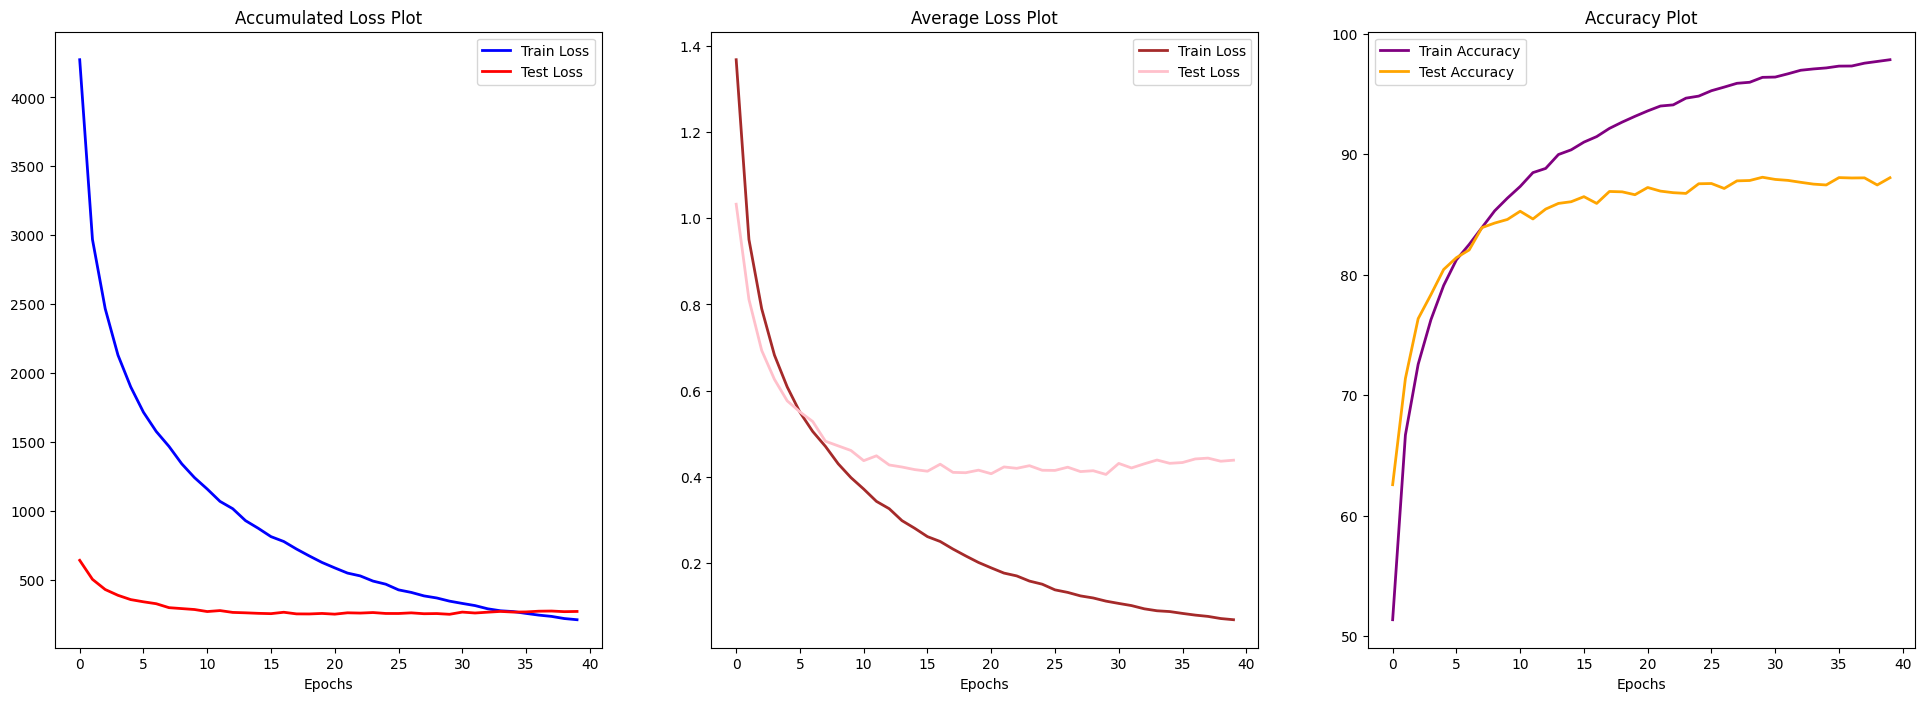

In [ ]:
## PLOT FOR STYLE 1
plot_result(train_loss_dict, test_loss_dict, train_accuracy_list, test_accuracy_list)

## Evaluating - STYLE 1

In [ ]:
## EVALUATING FOR STYLE 1
## Getting the prediction on the test set

## Set the eval() mode on
model1.eval()

with torch.no_grad():
    ## Variables for computing accuracy
    correct = 0
    total = 10000
    for i, (images, labels) in enumerate(test_loader):
        ## Assign images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        ## Compute the prediction of model on train batch
        labels_pred = model1(images)
        ## Compute correct predicition on test set
        _, predicted = torch.max(labels_pred.data, 1)
        correct += (predicted == labels).sum().item()

    ## Compute train accuracy and add to list
    test_accuracy = 100 * correct / total
    print('Final accuracy on test set is: {}'.format(test_accuracy))

Final accuracy on test set is: 89.4


## Training - STYLE 2

In [ ]:
## TRAIN FOR STYLE 2
## Learning rate --> Adam: lr = 0.0005
learning_rate = 0.0005
model2 = Backbone2(num_classes=10, num_block=4, block_size=2, output_channel=(64,128,256,512), max_pool=(False,True,True,True))
model2.to(device)
train_loss_dict, test_loss_dict, train_accuracy_list, test_accuracy_list = train(model2, train_loader, test_loader, epochs=40, learning_rate=learning_rate)

Epoch [1/40], Train Loss: 4125.7861, Test Loss: 604.7711, Train Accuracy: 53.0400, Test Accuracy: 65.5900
Epoch [2/40], Train Loss: 2741.4634, Test Loss: 489.4497, Train Accuracy: 69.3060, Test Accuracy: 72.7500
Epoch [3/40], Train Loss: 2226.2209, Test Loss: 418.3406, Train Accuracy: 75.4480, Test Accuracy: 77.1300
Epoch [4/40], Train Loss: 1902.8143, Test Loss: 357.5834, Train Accuracy: 79.0460, Test Accuracy: 80.3100
Epoch [5/40], Train Loss: 1679.5969, Test Loss: 331.5164, Train Accuracy: 81.5360, Test Accuracy: 82.0000
Epoch [6/40], Train Loss: 1508.0797, Test Loss: 304.5918, Train Accuracy: 83.5160, Test Accuracy: 83.2800
Epoch [7/40], Train Loss: 1345.7335, Test Loss: 288.0441, Train Accuracy: 85.1700, Test Accuracy: 84.4300
Epoch [8/40], Train Loss: 1237.3761, Test Loss: 290.6329, Train Accuracy: 86.3820, Test Accuracy: 83.9500
Epoch [9/40], Train Loss: 1114.9037, Test Loss: 273.3875, Train Accuracy: 87.6900, Test Accuracy: 85.3500
Epoch [10/40], Train Loss: 1031.1993, Test Los

## Plots - STYLE 2

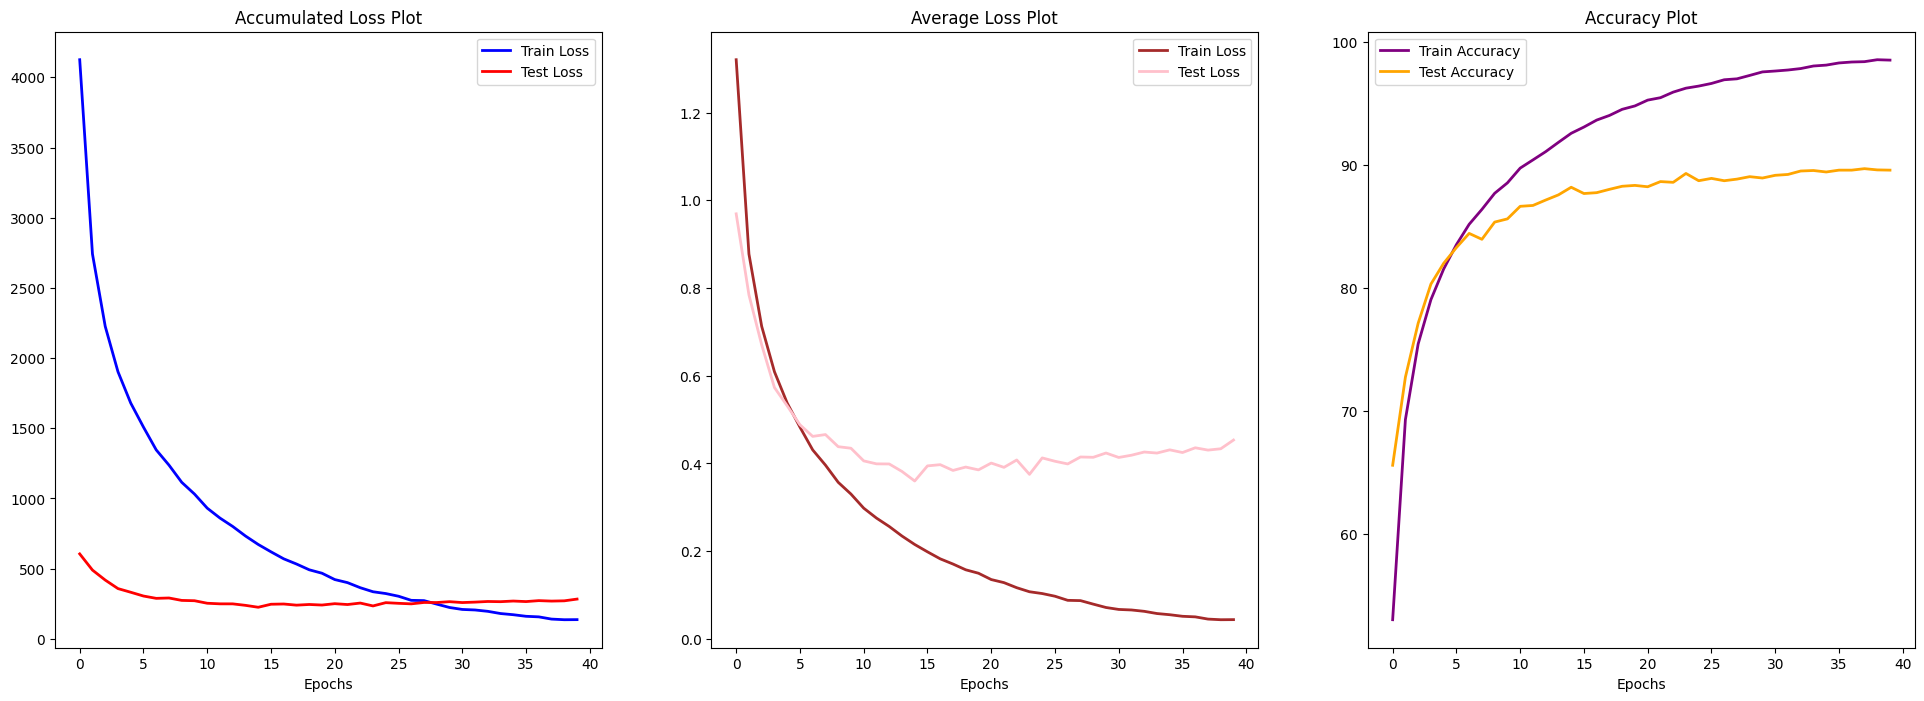

In [ ]:
## PLOT FOR STYLE 2
plot_result(train_loss_dict, test_loss_dict, train_accuracy_list, test_accuracy_list)

## Evaluating - STYLE 2

In [ ]:
## EVALUATING FOR STYLE 2
## Getting the prediction on the test set

## Set the eval() mode on
model2.eval()

with torch.no_grad():
    ## Variables for computing accuracy
    correct = 0
    total = 10000
    for i, (images, labels) in enumerate(test_loader):
        ## Assign images and labels to GPU
        images = images.to(device)
        labels = labels.to(device)
        ## Compute the prediction of model on train batch
        labels_pred = model2(images)
        ## Compute correct predicition on test set
        _, predicted = torch.max(labels_pred.data, 1)
        correct += (predicted == labels).sum().item()

    ## Compute train accuracy and add to list
    test_accuracy = 100 * correct / total
    print('Final accuracy on test set is: {}'.format(test_accuracy))

Final accuracy on test set is: 90.48
